In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-11-14 15:03:55.525608: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 15:03:55.563431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)

In [3]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img
def get_feature_vector(img_path):
  img = load_image(img_path)
  img = tf.expand_dims(img, axis=0)
  feature_vector = inception_v3(img)
  return img,feature_vector


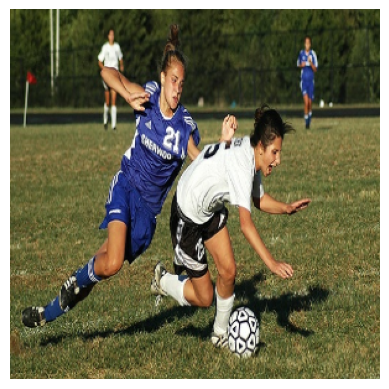


input img size   : (1, 299, 299, 3)
feature vector size : (1, 8, 8, 2048)


In [5]:
import os
path="/opt/evalify/evalify/images/"
img,feature_vector = get_feature_vector(os.path.join(path,"47871819_db55ac4699.jpg"))

plt.imshow(np.squeeze(img, axis=0))
plt.axis("off")
plt.show()

print()
print("input img size   :", img.shape)
print("feature vector size :", feature_vector.shape)


In [6]:
import re
def preprocess(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]','',text)
  text = re.sub(r'\s+',' ',text)
  text = text.strip()
  text = '[start] ' + text + '[end]'
  return text

In [7]:
import pandas as pd

# Load the captions from the file
with open(os.path.join(path,"captions_with_faces.txt"), "r") as f:
    data = f.readlines()

# Split each line by ':' and store as filename and caption
captions = []
for line in data:
    filename, caption = line.strip().split(":", 1)
    captions.append({"filename": filename.strip(), "caption": caption.strip()})

# Create DataFrame
captions_df = pd.DataFrame(captions)

# Display the column names to ensure it worked correctly
print(captions_df.columns)

# Apply any additional preprocessing to the 'caption' column
captions_df['caption'] = captions_df['caption'].apply(preprocess)

# Verify
print(captions_df.head())


Index(['filename', 'caption'], dtype='object')
                    filename  \
0  1000268201_693b08cb0e.jpg   
1  1002674143_1b742ab4b8.jpg   
2  1007129816_e794419615.jpg   
3  1007320043_627395c3d8.jpg   
4  1015118661_980735411b.jpg   

                                             caption  
0  [start] a little girl in a pink dress going in...  
1  [start] young girl with pigtails painting outs...  
2  [start] the man with pierced ears is wearing g...  
3  [start] the small child climbs on a red ropes ...  
4  [start] smiling boy in white shirt and blue je...  


In [92]:
max_length = 20
vocabulary_size = 10000

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    output_sequence_length=max_length
)

# Make sure to call adapt() with your caption data
tokenizer.adapt(captions_df['caption'].to_list())

In [93]:
tokenizer(["this pink is jeans"])

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[1313,   74,    7,  207,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [94]:
MAX_LENGTH = 20
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

In [95]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [96]:
import os
import random
import pandas as pd
from collections import defaultdict

# Path to the directory where images are stored
image_dir = path # Update with your actual image directory path

# Assuming 'captions' is the list of dictionaries created earlier
captions_df = pd.DataFrame(captions)  # Create DataFrame from the list of dictionaries

# Verify the DataFrame structure
print(captions_df.columns)  # Ensure the columns are 'filename' and 'caption'

# Dictionary to map each image path to a list of captions
img_to_cap_vector = defaultdict(list)

# Associate each image path with its captions
for img_name, cap in zip(captions_df['filename'], captions_df['caption']):
    img_path = os.path.join(image_dir, img_name)  # Full path to the image file
    img_to_cap_vector[img_path].append(cap)

# Shuffle and split image paths into training and validation sets (80-20 split)
img_paths = list(img_to_cap_vector.keys())
random.shuffle(img_paths)

split_index = int(len(img_paths) * 0.8)
train_img_paths, val_img_paths = img_paths[:split_index], img_paths[split_index:]

# Create training and validation lists
train_imgs, train_captions = [], []
for img_path in train_img_paths:
    captions_list = img_to_cap_vector[img_path]
    train_imgs.extend([img_path] * len(captions_list))  # Add image path multiple times
    train_captions.extend(captions_list)               # Add corresponding captions

val_imgs, val_captions = [], []
for img_path in val_img_paths:
    captions_list = img_to_cap_vector[img_path]
    val_imgs.extend([img_path] * len(captions_list))   # Add image path multiple times
    val_captions.extend(captions_list)                 # Add corresponding captions

# Verify the lengths to ensure data consistency
print(f"Number of training images: {len(train_imgs)}, Number of training captions: {len(train_captions)}")
print(f"Number of validation images: {len(val_imgs)}, Number of validation captions: {len(val_captions)}")


Index(['filename', 'caption'], dtype='object')
Number of training images: 3355, Number of training captions: 3355
Number of validation images: 839, Number of validation captions: 839


In [97]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(3355, 3355, 839, 839)

In [98]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

In [99]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [100]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

In [101]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

In [102]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [103]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

In [104]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

TensorShape([32, 20, 512])

In [105]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [106]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [107]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

In [108]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=cross_entropy
)

In [109]:
history = caption_model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
)


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - acc: 0.0856 - loss: 6.1181 - val_loss: 5.3591 - val_acc: 0.1467
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - acc: 0.1802 - loss: 5.0480 - val_loss: 4.6456 - val_acc: 0.2177
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - acc: 0.2538 - loss: 4.2428 - val_loss: 4.3557 - val_acc: 0.2550
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - acc: 0.2878 - loss: 3.8260 - val_loss: 4.3204 - val_acc: 0.2551
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - acc: 0.3224 - loss: 3.4444 - val_loss: 4.2871 - val_acc: 0.2612
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - acc: 0.3470 - loss: 3.1588 - val_loss: 4.3687 - val_acc: 0.2669
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - acc: 0.3841 - loss: 2.8728 - val_loss: 4.4100 - val_acc: 0.2584
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 248ms/step - acc: 0.4161 - loss: 2.6003 - val_loss: 4.5374 - val_acc: 0.2667
Epoch 9/20
105/105 ━━━━━━━━━━━━━

In [110]:
idx2word(2).numpy().decode('utf-8')

'a'

In [111]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

In [112]:
val_imgs

['/opt/evalify/evalify/images/351876121_c7c0221928.jpg',
 '/opt/evalify/evalify/images/2980118787_2099de53ec.jpg',
 '/opt/evalify/evalify/images/2751567262_e089b33ed9.jpg',
 '/opt/evalify/evalify/images/3244747165_17028936e0.jpg',
 '/opt/evalify/evalify/images/242109387_e497277e07.jpg',
 '/opt/evalify/evalify/images/3046916429_8e2570b613.jpg',
 '/opt/evalify/evalify/images/3372167201_f7f909d480.jpg',
 '/opt/evalify/evalify/images/2150564996_d173a506d7.jpg',
 '/opt/evalify/evalify/images/3091382602_60b9b53ed1.jpg',
 '/opt/evalify/evalify/images/2942094037_f6b36fd3db.jpg',
 '/opt/evalify/evalify/images/3421789737_f625dd17ed.jpg',
 '/opt/evalify/evalify/images/3332202255_a30c522664.jpg',
 '/opt/evalify/evalify/images/3474985112_24ef46e82d.jpg',
 '/opt/evalify/evalify/images/3394750987_a32ecc477e.jpg',
 '/opt/evalify/evalify/images/630476551_2ee7399f77.jpg',
 '/opt/evalify/evalify/images/2845845721_d0bc113ff7.jpg',
 '/opt/evalify/evalify/images/1773928579_5664a810dc.jpg',
 '/opt/evalify/ev

In [1]:
from PIL import Image
import random
idx = random.randrange(0, len(val_imgs))
img_path = val_imgs[idx]
pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)

NameError: name 'random' is not defined

In [159]:
idx

321